In [60]:
import os
import cv2
import random
import numpy as np
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
# import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization, Conv2D
from tensorflow.keras.layers import AveragePooling2D, Dense, Input, Lambda, concatenate
from tensorflow.keras.optimizers import RMSprop, Adam

In [36]:
folders = sorted(os.listdir("data_organized"))
train_val_patients = []
test_patients = []
test_count = 0
random.shuffle(folders)

for name in folders:
    train_val_patients.append(name)
    
for name in folders:
    _, count = name.split('+')
    # Fill up test_patients with 62 first
    count = int(count)
    if test_count+count <= 62:
        test_patients.append(name)
        test_count += count
        train_val_patients.remove(name)
        if test_count == 62:
            break
    elif test_count+count > 62:
        continue
        
print(test_count)

62


In [37]:
# Read in files from folders, store as np arrays of images (X_train) and clinsig labels (y_train)
# clinsig TRUE = 1, FALSE = 0
X_clinsig = []
y_clinsig = []

X_indolent = []
y_indolent = []

for folder in train_val_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray)) 
        if adc_t2 == 't2':
            if label == 'TRUE':
                X_clinsig.append(array)
                y_clinsig.append(1)
            else:
                X_indolent.append(array)
                y_indolent.append(0)

# Random over-sampling to remedy imbalanced dataset
print('Original: indolent={}, clinsig={}'.format(len(y_indolent), len(y_clinsig)))

Original: indolent=194, clinsig=62


In [38]:
# Generate imgaes of minority class (clinsig)
X = []
y = []
X.extend(X_indolent)
X.extend(X_clinsig)
y.extend(y_indolent)
y.extend(y_clinsig)

datagen = ImageDataGenerator(
#                     rescale=1./255,
                    shear_range=0.05,
#                     zoom_range=[,1],
                    rotation_range=90,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
    
X_clinsig = np.array(X_clinsig)
y_clinsig = np.array(y_clinsig)
np.asarray(y_clinsig).astype('float32').reshape((-1,1))

for img in X_clinsig:
    img = img.reshape((1,) + img.shape)
    for x, val in zip(datagen.flow(img, batch_size=1), range(2)):
        im = x[0]
        X.append(im)
        y.append(1)

X = np.array(X)
y = np.array(y)
print(Counter(y))
print(len(X), len(y))

Counter({0: 194, 1: 186})
380 380


In [39]:
X, y = shuffle(X, y)

# Now split this into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2)

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)
print("ntrain={}, nval={}".format(ntrain, nval))

ntrain=285, nval=95


In [40]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
# conv_base.summary()

In [51]:
chanDim = 3

model = tf.keras.Sequential()
model.add(conv_base)

model.add(Conv2D(32, (3, 3), padding="same")) # kernel_initializer=init ? 
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))

for i in range(9):
    model.add(Conv2D(32, (3, 3), padding="same")) 
    model.add(BatchNormalization(axis=chanDim))
    model.add(Activation("relu"))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(BatchNormalization(axis=chanDim))
    
model.add(AveragePooling2D(pool_size=(3, 3), padding="same"))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #Sigmoid function at the end because we have just two classes

# model.summary()

In [52]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

# binary_crossentropy loss because its a binary classification
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=1e-5), metrics=['acc'])
# model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=3e-4), metrics=['acc'])

Number of trainable weights before freezing the conv base: 80
Number of trainable weights after freezing the conv base: 80


In [53]:
batch_size = 64

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

np.asarray(y_train).astype('float32').reshape((-1,1))
np.asarray(y_val).astype('float32').reshape((-1,1))

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [54]:
history = model.fit(train_generator,
                    steps_per_epoch=ntrain//batch_size,
                    epochs=170,
                    validation_data=val_generator,
                    validation_steps=nval//batch_size)

Epoch 1/170
4/4 [==============================] - 5s 1s/step - loss: 0.7148 - acc: 0.5023 - val_loss: 0.6932 - val_acc: 0.4688
Epoch 2/170
4/4 [==============================] - 1s 320ms/step - loss: 0.7328 - acc: 0.4389 - val_loss: 0.6930 - val_acc: 0.5469
Epoch 3/170
4/4 [==============================] - 1s 321ms/step - loss: 0.7075 - acc: 0.4805 - val_loss: 0.6930 - val_acc: 0.5312
Epoch 4/170
4/4 [==============================] - 1s 357ms/step - loss: 0.7170 - acc: 0.4706 - val_loss: 0.6930 - val_acc: 0.5312
Epoch 5/170
4/4 [==============================] - 1s 365ms/step - loss: 0.7110 - acc: 0.4389 - val_loss: 0.6930 - val_acc: 0.5312
Epoch 6/170
4/4 [==============================] - 2s 397ms/step - loss: 0.7046 - acc: 0.5204 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/170
4/4 [==============================] - 1s 329ms/step - loss: 0.7083 - acc: 0.4531 - val_loss: 0.6922 - val_acc: 0.6094
Epoch 8/170
4/4 [==============================] - 2s 386ms/step - loss: 0.7258 - acc:

4/4 [==============================] - 3s 755ms/step - loss: 0.6876 - acc: 0.5385 - val_loss: 0.6921 - val_acc: 0.5469
Epoch 64/170
4/4 [==============================] - 2s 503ms/step - loss: 0.6997 - acc: 0.4706 - val_loss: 0.6921 - val_acc: 0.5469
Epoch 65/170
4/4 [==============================] - 2s 489ms/step - loss: 0.6972 - acc: 0.5068 - val_loss: 0.6924 - val_acc: 0.5312
Epoch 66/170
4/4 [==============================] - 2s 556ms/step - loss: 0.6985 - acc: 0.5113 - val_loss: 0.6944 - val_acc: 0.4531
Epoch 67/170
4/4 [==============================] - 2s 406ms/step - loss: 0.7093 - acc: 0.4299 - val_loss: 0.6928 - val_acc: 0.5156
Epoch 68/170
4/4 [==============================] - 2s 426ms/step - loss: 0.6969 - acc: 0.4887 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 69/170
4/4 [==============================] - 3s 626ms/step - loss: 0.7010 - acc: 0.4932 - val_loss: 0.6937 - val_acc: 0.4844
Epoch 70/170
4/4 [==============================] - 2s 575ms/step - loss: 0.6961 - acc: 0

Epoch 125/170
4/4 [==============================] - 1s 233ms/step - loss: 0.6860 - acc: 0.5520 - val_loss: 0.6956 - val_acc: 0.5469
Epoch 126/170
4/4 [==============================] - 1s 251ms/step - loss: 0.6931 - acc: 0.5068 - val_loss: 0.6983 - val_acc: 0.4688
Epoch 127/170
4/4 [==============================] - 1s 207ms/step - loss: 0.6962 - acc: 0.5204 - val_loss: 0.6990 - val_acc: 0.4062
Epoch 128/170
4/4 [==============================] - 1s 217ms/step - loss: 0.6875 - acc: 0.4977 - val_loss: 0.7002 - val_acc: 0.4375
Epoch 129/170
4/4 [==============================] - 1s 205ms/step - loss: 0.6984 - acc: 0.5158 - val_loss: 0.6984 - val_acc: 0.4531
Epoch 130/170
4/4 [==============================] - 1s 179ms/step - loss: 0.6943 - acc: 0.5339 - val_loss: 0.6987 - val_acc: 0.3750
Epoch 131/170
4/4 [==============================] - 1s 174ms/step - loss: 0.6869 - acc: 0.5068 - val_loss: 0.6950 - val_acc: 0.4531
Epoch 132/170
4/4 [==============================] - 1s 191ms/step - 

In [55]:
model.save_weights('models/model_t2_weights.h5')
model.save('models/model_t2_keras.h5')

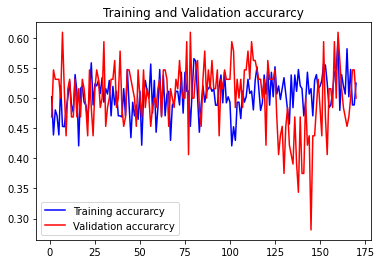

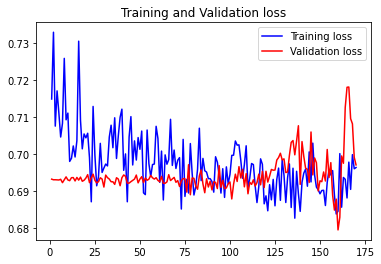

In [56]:
# Plot validation and losss

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

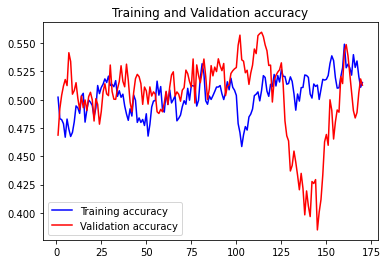

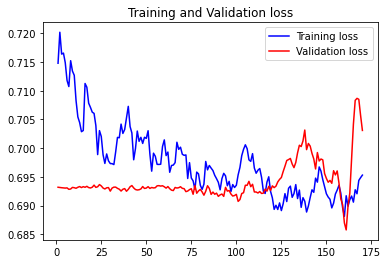

In [57]:
# Plot validation and losss with smoother lines

def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

#Plot figure
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accuracy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, smooth_plot(loss), 'b', label='Training loss')
plt.plot(epochs, smooth_plot(val_loss), 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [58]:
#Prepare test set

X_test = []
y_test = []

for folder in test_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        if adc_t2 == 't2':
            if label == 'TRUE':
                y_test.append(1)
            else:
                y_test.append(0)
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray))  
        if adc_t2 == 't2':
            X_test.append(array)

In [59]:
x = np.array(X_test)
y = np.array(y_test)
total = len(x)
test_datagen = ImageDataGenerator(rescale=1./255)

predictions = 0
correct = 0
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
i = 0
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    prediction = 1 if pred > 0.5 else 0
    actual = 1 if y[i] == 1 else 0
    if prediction == actual:
        correct += 1
        if prediction == 1:
            true_pos += 1
        else:
            true_neg += 1
    else:
        if prediction == 1 and actual == 0:
            false_pos += 1
        else:
            false_neg += 1
    predictions += prediction
    i += 1
    if i == total:
        break
    
print('ACCURACY: {}%'.format(correct/total * 100))
print('FALSE POSITIVE: {}%'.format(false_pos/(total-correct) * 100))
print('FALSE NEGATIVE: {}%'.format(false_neg/(total-correct) * 100))
print('TRUE POSITIVE: {}%'.format(true_pos/(correct) * 100))
print('TRUE NEGATIVE: {}%'.format(true_neg/(correct) * 100))
print('CLINICALLY SIGNIFICANT PREDICTION: {}%'.format(predictions/total * 100))

ACCURACY: 61.29032258064516%
FALSE POSITIVE: 62.5%
FALSE NEGATIVE: 37.5%
TRUE POSITIVE: 7.894736842105263%
TRUE NEGATIVE: 92.10526315789474%
CLINICALLY SIGNIFICANT PREDICTION: 29.03225806451613%
